# 12. Implementation of a Portfolio Strategy

This tutorial provides a step-by-step guide for implementing a Unit Operator with a Portfolio Strategy in the ASSUME framework. By the end of this guide, you will be familiar with the process of creating and integrating a Portfolio within the electricity market simulation environment provided by ASSUME.


**We will cover the following topics:** #TODO

1. [Introduction to Unit Operators and Portfolio Strategy](#1-introduction-to-unit-operators-and-portfolio-strategy)
2. [Setting up the ASSUME framework](#2-setting-up-assume)
3. [Developing a UnitOperatorStrategy](#3-developing-a-new-demand-side-unit)
4. [Formulating a rule-based bidding strategy](#4-rule-based-bidding-strategy)
5. [Integrating the new strategy into the ASSUME simulation](#5-integrating-the-new-strategy-into-assume)

## 1. Introduction to Units Operator and Portfolio Strategy

The ASSUME framework is a versatile tool for simulating electricity markets, allowing researchers and industry professionals to analyze market dynamics and strategies.

A **UnitsOperator** in ASSUME refers to a market role that submits buy or sell bids in the market for multiple units in its portfolio, according to the bidding strategy of each unit. Unit operators can themselves have a portfolio strategy, that is a **UnitOperatorStrategy**, which aims at optimizing the joint market returns from the bids of all units of the operator. 

In this tutorial, we will create a portfolio strategy for a unit operator with multiple units.

# Understanding pivotality

For the purpose of this tutorial, we will introduce the concept of pivotality:
For a given time period, a unit operator is **pivotal** if the market demand cannot be covered by the supply capacity without the capacity of the units in the operator's portfolio.


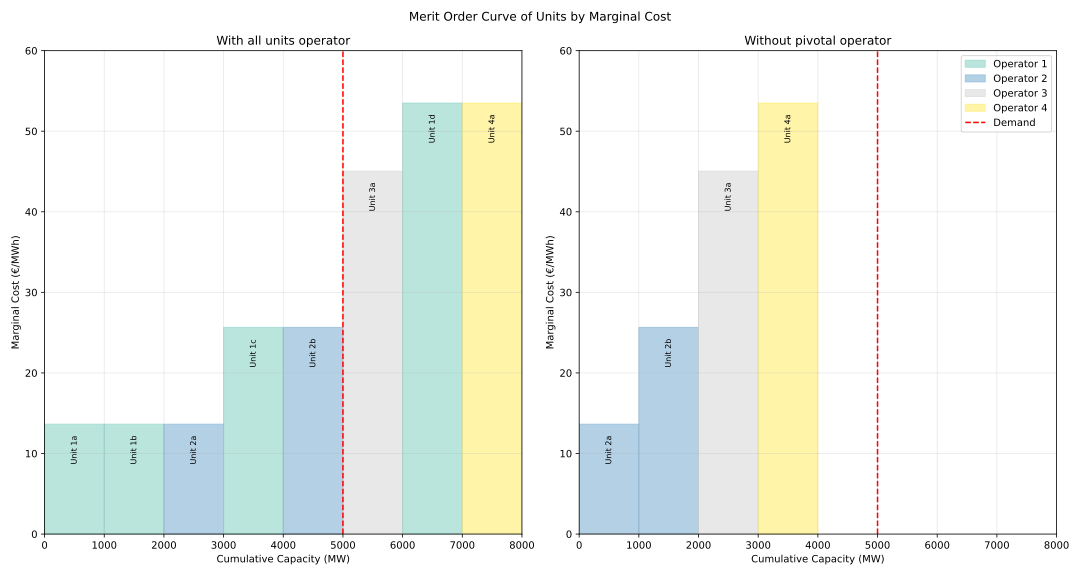

In [1]:
# this cell is used to display the image in the notebook when using colab
# or running the notebook locally

import os
import matplotlib.pyplot as plt
from IPython.display import Image, display, SVG

image_path = "assume-repo/docs/source/img/pivotal_units_operator.svg"
alt_image_path = "../../docs/source/img/pivotal_units_operator.svg"

# Try to display SVG using different methods
if os.path.exists(image_path):
    display(SVG(image_path))
elif os.path.exists(alt_image_path):
    display(SVG(alt_image_path))
else:
    print("Image file not found. Please check the path.")


The picture provides a visual representation of the concept of pivotality. Both images represent the Merit Order Curve of the generation units in a market, sorted by their marginal cost and colored by their operator. The market demand is inflexible and amounts to 5000 MW.
- **Left-hand side**: complete Merit Order Curve
- **Right-hand side**: Merit Order Curve without Operator 1 (pivotal operator).

With pivotality, the unit operator has an incentive to bid extremely high prices for the units in its portfolio, as its generation capacity is required to clear the market. However, this behavior cannot be represented in the individual bidding strategy of the units, as none of them is individually pivotal. This is just an example of how optimal portfolio bidding may differ from optimal unit bidding.

## 2. Setting Up ASSUME

Before we create our custom unit, let's set up the ASSUME framework. We'll install the ASSUME core package and clone the repository containing predefined scenarios.

**You don't need to execute the following code cells if you already have the ASSUME framework installed and/or the repository cloned.**

In [2]:
import importlib.util

# Check if 'google.colab' is available
IN_COLAB = importlib.util.find_spec("google.colab") is not None
if IN_COLAB:
    !pip install assume-framework

In [3]:
if IN_COLAB:
    !git clone --depth=1 https://github.com/assume-framework/assume.git assume-repo

Note that Google Colab does not support Docker functionalities, so features dependent on Docker will not be available here.

**Select input files path**

We also need to differentiate between the input file paths when using this tutorial in Google Colab and a local environment. The code snippets will include both options for your convenience.

In [4]:
colab_inputs_path = "assume-repo/examples/inputs"
local_inputs_path = "../inputs"

inputs_path = colab_inputs_path if IN_COLAB else local_inputs_path

**Loading predefined scenario**

We load a predefined scenario with a strategic operator, **Operator 1**, which will implement portfolio-level strategies.

In [5]:
#TODO
import os, sys
sys.path.append(os.path.abspath("../../"))
from assume import World
from assume.scenario.loader_csv import load_scenario_folder
%load_ext autoreload
%autoreload 2

inputs_path = "../inputs"
db_uri = "sqlite:///../local_db/assume_db.db"

world = World(database_uri=db_uri, export_csv_path=f"outputs/12_portfolio_strategies")
load_scenario_folder(
    world,
    inputs_path=inputs_path,
    scenario="example_01i",
    study_case=False,
)


INFO:assume.world:Connected to the database
INFO:assume.scenario.loader_csv:Input files path: ../inputs/example_01i
INFO:assume.scenario.loader_csv:Study case: False
INFO:assume.scenario.loader_csv:Simulation ID: example_01i_base
INFO:assume.scenario.loader_csv:storage_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:Downsampling exchanges_df successful.
INFO:assume.scenario.loader_csv:availability_df not found. Returning None
INFO:assume.scenario.loader_csv:buses not found. Returning None
INFO:assume.scenario.loader_csv:lines not found. Returning None
INFO:assume.scenario.loader_csv:save_frequency_hours is disabled due to CSV export being enabled. Data will be stored in the CSV 

## 3. Developing a New Forecast

In order for the Units Operator to be able to act strategically when it is pivotal, it needs to have access to a forecast of total market demand and residual supply. The residual supply is the total available supply of units which do ***not*** belong to the unit operator. 

We equip the unit operator with a **CSVForecaster**, which is a Forecaster object that contains multiple datasets for a given scenario. The simulation receives a global forecaster as a **CSVForecaster** object when the scenario is loaded. We use a copy of the global forecaster as the basis for the operator forecaster, and add an additional private information - the forecast of the residual supply for Operator 1.


In [6]:
from assume.common.fast_pandas import FastSeries
from assume.common.forecasts import CsvForecaster
from copy import deepcopy


def add_res_supply_forecast(global_forecaster:CsvForecaster, 
                            operator_id:str):
    """Creates a copy of a forecaster object which
    includes the residual supply without the operator, 
    calculated as the sum of the available capacity of
    all power plants that do not belong to it. 

    Args:
        global_forecaster(CSVForecaster): original forecaster
        operator_id(str): identifier of the UnitsOperator

    Returns:
        op_forecaster(CSVForecaster): forecaster of the UnitsOperator
     """
    
    op_forecaster = deepcopy(global_forecaster)
    fcst_dict = op_forecaster.forecasts
    fcst_name = f"res_supply_{operator_id}"

    if fcst_name in fcst_dict:
        return op_forecaster

    res_supply_forecast = FastSeries(
                    value=0.0, 
                    index=op_forecaster.index, 
                    name=fcst_name,
                )

    for unit_id, unit in op_forecaster.powerplants_units.iterrows():    
        if unit["unit_operator"] == operator_id:
            continue 
        
        else:
            # add to the residual supply 
            availability = fcst_dict[f"availability_{unit_id}"]
            res_supply_forecast+= (availability * unit["max_power"])
        
    fcst_dict[fcst_name] = res_supply_forecast
    return op_forecaster


## 4. Developing a New Portfolio Strategy

Now, we'll define a rule-based portfolio strategy for a Units Operator. This strategy will use market information on the demand forecast to place bids at a higher price if the operator expects to be pivotal. Whenever the forecasted demand is higher than the total supply of other units operator, the UnitsOperator will strategically bid the unit with the highest marginal cost at a higher price (`pivotal_price`.)

**Key features of a Portfolio Strategy**
1. **Prioritized over unit bidding strategies**: the portfolio strategies of an operator is called before the bidding strategies of individual units and can overwrite them.
2. **Transforms a portfolio strategy into unit bids**: The portfolio-level strategy is translated into bids that are assigned to the units in the portfolio. This ensures that the market clearing can be used to determine the dispatch of the units. 
3. **Calculates operator reward**: Rewards are computed at a portfolio-level, if needed.

**Default UnitsOperatorStrategy**

Units Operators without a portfolio strategy receive a `DirectUnitOperatorStrategy`, which calculates the bids of each unit according to their strategy unit operator and include additional information, such as `bid_id` and `unit_id`.


In [25]:
from assume.strategies.portfolio_strategies import UnitOperatorStrategy
from assume.common.market_objects import MarketConfig, Product, Orderbook
from itertools import groupby
from operator import itemgetter

class PivotalityStrategy(UnitOperatorStrategy):

    def __init__(self, *args, **kwargs):
        # sets the price to bid when operator is pivotal
        self.pivotal_price = kwargs.get("pivotal_price", 100)

    def calculate_bids(
            self,
            units_operator,  # type: UnitsOperator
            market_config: MarketConfig,
            product_tuples: list[Product],
            **kwargs,
        ) -> Orderbook:
        """
        Takes information from a units operator and
        defines how the units managed by it should bid.

        This gives a lot of flexibility to the market bids.

        Args:
            units_operator (UnitsOperator): The operator handling the units.
            market_config (MarketConfig): The market configuration.
            product_tuples (list[Product]): The list of all products the unit can offer.

        Returns:
            Orderbook: The bids consisting of the start time, end time, only hours, price and volume.
        """
        
        original_bids = [] 
        operator_bids = []
  
        op_id = units_operator.id
        market_id = market_config.market_id

        demand_fcst =  units_operator.forecaster[f"demand_{market_id}"]
        res_supply_fcst  = units_operator.forecaster[f"res_supply_{op_id}"]
        uncovered_demand = (demand_fcst - res_supply_fcst)

        # Calculates unit bids according to their individual strategy
        for unit in units_operator.units.values():
            unit_bids = unit.calculate_bids(market_config, product_tuples)
            original_bids.extend(unit_bids)
            # add bid_id and unit_id
            for bid in unit_bids:
                bid["bid_id"] = f"{units_operator.id}_{unit.id}"
                bid["unit_id"] = unit.id

        
        product_getter = itemgetter("start_time", "end_time")
        original_bids = sorted(original_bids, key=product_getter)
        
        # Select power plants with highest bid for each product
        for prod, bids_group in groupby(original_bids, product_getter):
            bids_group = list(bids_group)
            max_bid = max(b["price"] for b in bids_group)
            start = prod[0]

            for bid in bids_group:
                # if operator is pivotal for the product, increase its bid price
                if uncovered_demand[start] > 0 and bid["price"] == max_bid:
                    bid["price"] = max(max_bid, self.pivotal_price)
            
            operator_bids.extend(bids_group)
        
        return operator_bids

## 5. Modifying the UnitsOperator in ASSUME

Now we'll test integrating our updated forecaster and portfolio strategy into the ASSUME simulation environment.

First, we'll define and run a simulation without any portfolio optimization as a baseline test, saving results to "outputs/12_portfolio_strategies/example_01i_base".

In [8]:
world.run()

example_01i_base 2019-01-30 23:00:00: 100%|█████████▉| 2588401/2592000 [00:06<00:00, 427094.67it/s]


Next we define and run the simulation again, this time adding a portfolio strategy and a forecaster to the units operator, saving results to "outputs/12_portfolio_strategies/example_01i_strategic_operator".

In [26]:
# reset and reload the simulation
from assume.scenario.loader_csv import load_config_and_create_forecaster, setup_world

world.reset()

world.scenario_data = load_config_and_create_forecaster(
    inputs_path, scenario="example_01i", study_case=False
)

# change the simulation_id
new_simulation_id = "example_01i_strategic_operator"
world.scenario_data['simulation_id'] = new_simulation_id
world.simulation_id = new_simulation_id
setup_world(world=world)

INFO:assume.scenario.loader_csv:Input files path: ../inputs/example_01i
INFO:assume.scenario.loader_csv:Study case: False
INFO:assume.scenario.loader_csv:Simulation ID: example_01i_base
INFO:assume.scenario.loader_csv:storage_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:Downsampling exchanges_df successful.
INFO:assume.scenario.loader_csv:availability_df not found. Returning None
INFO:assume.scenario.loader_csv:buses not found. Returning None
INFO:assume.scenario.loader_csv:lines not found. Returning None
INFO:assume.scenario.loader_csv:save_frequency_hours is disabled due to CSV export being enabled. Data will be stored in the CSV files at the end of the simulation.
INFO:ass

In [27]:
operator_1 = world.unit_operators["Operator 1"]
# add the forecaster to the operator
op_forecaster = add_res_supply_forecast(world.forecaster, "Operator 1")
operator_1.forecaster = op_forecaster
# add the dictionary of portfolio strategies by market_id to the operator
# add new bidding strategy to world
world.bidding_strategies["portfolio_pivotality"] = PivotalityStrategy
operator_1.portfolio_strategies = {"EOM": PivotalityStrategy()}

world.run()

example_01i_strategic_operator 2019-01-30 23:00:00: 100%|█████████▉| 2588401/2592000 [00:12<00:00, 205464.52it/s]


After running both simulations, we can now compare them through loading the CSV output files and plotting the results. To make visualisation easier, we focus on a 3-month period (Jan 1st - Mar 1st, 2019).

In [28]:
import pandas as pd
from datetime import datetime

test_types = ["base", "strategic_operator"]

dispatch_dfs = {}
op1_supply_dfs = {}
price_dfs = {}
op1_bids_dfs = {}

#start, end = datetime(2019, 1, 1), datetime(2019, 3, 1)

for test in test_types:
    #read units of Operator 1
    units_df = pd.read_csv(
        f"outputs/12_portfolio_strategies/example_01i_{test}/power_plant_meta.csv", index_col=0
    )
    op1_units = units_df[units_df["unit_operator"] == "Operator 1"].index.tolist()
    
    dispatch_df = pd.read_csv(
        f"outputs/12_portfolio_strategies/example_01i_{test}/market_dispatch.csv", index_col=1
    )
    dispatch_df.index = pd.to_datetime(dispatch_df.index)

    dispatch_df = dispatch_df.pivot(columns="unit_id", values="power")
    dispatch_dfs[test] = dispatch_df

    # demand_df = dispatch_df["demand_EOM"] * -1
    # demand_dfs[test] = demand_df
    # supply_df = dispatch_df[
    #                         c for col in dispatch_df.columns 
    #                         if c in op1_units
    #                         ].sum(axis=1)
    # op1_supply_dfs[test] = supply_df
    
    price_df = pd.read_csv(
        f"outputs/12_portfolio_strategies/example_01i_{test}/market_meta.csv", index_col=0
    )
    price_df.index = pd.to_datetime(price_df["product_start"])
    price_df = price_df.loc[price_df["market_id"] == "EOM", "price"]
    price_dfs[test] = price_df

    bids = pd.read_csv(
        f"outputs/12_portfolio_strategies/example_01i_{test}/market_orders.csv", index_col=0
    )
    bids.index = pd.to_datetime(bids.index)
    op1_bids = bids[bids["unit_id"].isin(op1_units)].pivot(columns="unit_id", values="price")
    op1_bids_dfs[test] = op1_bids
    
    



base
strategic_operator


C:\Users\c.fusarbassini\AppData\Local\Temp\ipykernel_7924\3817218576.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\c.fusarbassini\AppData\Local\Temp\ipykernel_7924\3817218576.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


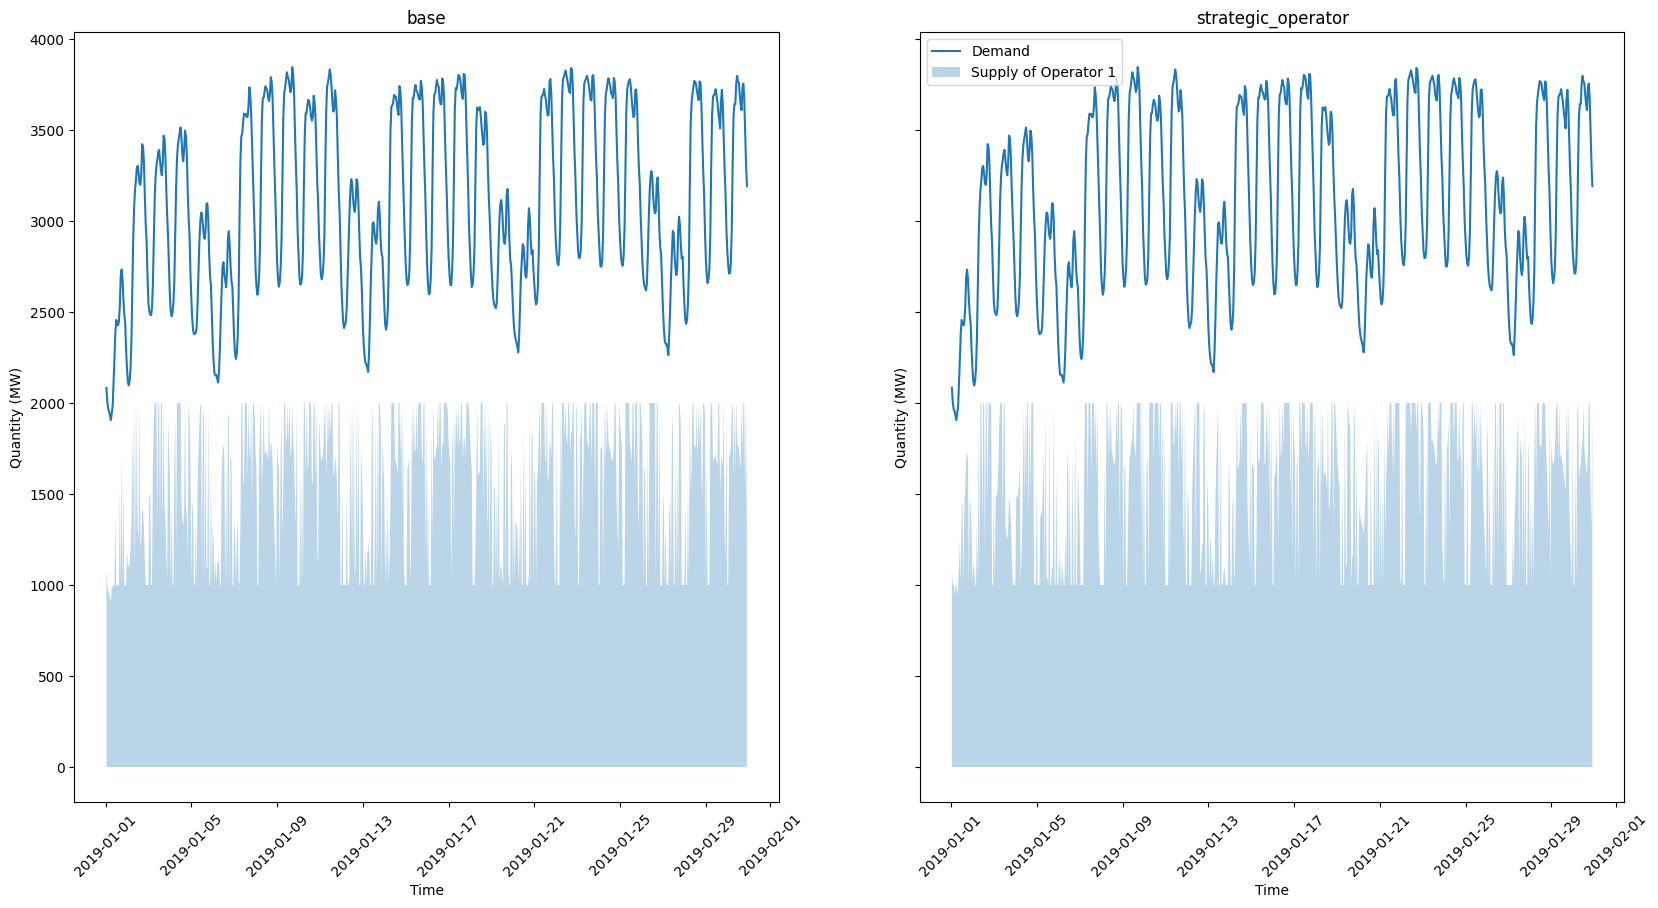

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(20, 10), sharey=True)

for ax, scenario in zip(axes, test_types):
    
    ax.plot(
        dispatch_dfs[scenario].index.to_list(),
        dispatch_dfs[scenario]["demand_EOM"] * -1,
        label="Demand",
    )
    ax.fill_between(
        dispatch_dfs[scenario].index.to_list(),
        dispatch_dfs[scenario][op1_units].sum(axis=1),
        label="Supply of Operator 1",
        alpha=0.3,
    )
    print(scenario)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel("Time")
    ax.set_ylabel("Quantity (MW)")
    ax.set_title(scenario)

ax.legend()

In the plot above, what's most noticeable is that the Power Plant sufficiently meets the load requirements, and the Gas Plant is never on. ("+" values = Generation, "-" values = Load).

Now we'll see how adding the Electrolyser affects Power Dispatch. 

| Operator    | Installed capacity (MW) | Tot. dispatch MWh (baseline) | Tot. revenues €/MWh (baseline) | Tot. dispatch MWh (strategic) | Tot. revenues €/MWh (strategic) |
|----------|-----|-----|-----------|-----------|-----------|
| Operator 1  | 2500    | 1,123,516.5   | 28,748,134.9  |   730,082.6 | 21,855,554.9
| Operator 2  | 1000    | 717,856.4     | 18,342,639.6  |   717,848.9 | 
| Operator 3  | 1000    | 394,380.5     | 10,115,858.5  |   441,321.9 |
| Operator 4  | 1500    | 0.0           | 0.0           |   346,500.0 |


In [31]:
revenues_base = dispatch_dfs['base'].apply(lambda x: x*price_dfs['base'], axis=0).sum()
revenues_strategic = dispatch_dfs['strategic_operator'].apply(lambda x: x*price_dfs['strategic_operator'], axis=0).sum()

**Comparing prices**

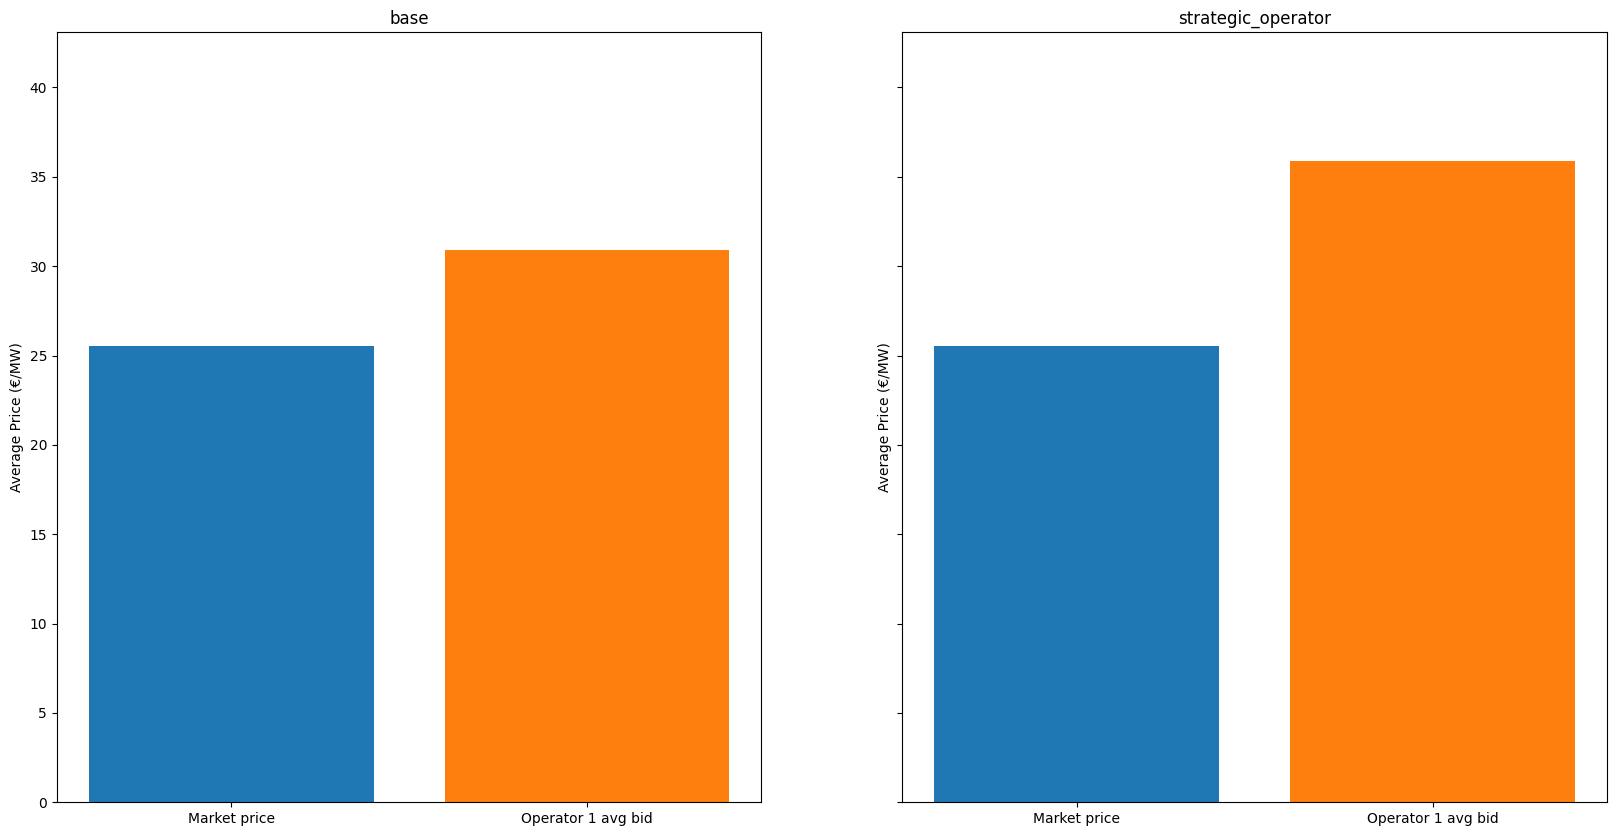

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(20, 10), sharey=True)
for ax, scenario in zip(axes, test_types):
    # Calculate average market price and average bid price of Operator 1 for the scenario
    avg_market_price = price_dfs[scenario].mean()
    avg_op1_bid_price = op1_bids_dfs[scenario].mean().mean()  # mean over time and units

    # Bar plot for average prices
    ax.bar(
        ["Market price", "Operator 1 avg bid"],
        [avg_market_price, avg_op1_bid_price],
        color=["tab:blue", "tab:orange"],
    )
    ax.set_title(f"{scenario}")
    ax.set_ylabel("Average Price (€/MW)")
    ax.set_ylim(0, max(avg_market_price, avg_op1_bid_price) * 1.2)


# for ax, scenario in zip(axes, test_types):
    
#     ax.plot(
#         price_dfs[scenario].mean(),
#         price_dfs[scenario].values,
#         label="Market price",
#     )
#     # ax.plot(
#     #     op1_bids_dfs[scenario].index.to_list(),
#     #     op1_bids_dfs[scenario].max(axis=1).values,
#     #     label="Max bid of Operator 1",
#     # )
    
#     ax.set_xlabel("Time")
#     ax.set_ylabel("Price (€/MW)")
#     ax.set_title(scenario)

# ax.legend()

This concludes our tutorial. By following these steps, you have successfully created a Portfolio Strategy for a UnitsOperator and integrated it into the ASSUME framework.